<a href="https://colab.research.google.com/github/eunzzae/Study_DS/blob/main/5)_%ED%92%88%EC%A7%88_%EC%A4%91%EC%9A%94%EC%9D%B8%EC%9E%90_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 품질 중요인자 분석  
> **목차(Context)**

* 문제상황 및 데이터 살펴보기  
* 문제해결 프로세스 정의  
1) 품질 중요인자 탐색  
2) 선형회귀 활용 중요인자 도출  
3) ML 활용 품질 중요인자 도출

In [1]:
# ▶ Warnings 제거
import warnings
warnings.filterwarnings('ignore')

# ▶ Google drive mount or 폴더 클릭 후 구글드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

# # ▶ 경로 설정 (※ Colab을 활성화시켰다면 보통 Colab Notebooks 폴더가 자동 생성)
# import os
# os.chdir('/content/drive/MyDrive/Colab Notebooks/part3_lecture_fastcampus/chapter05')
# # '/content/drive/MyDrive/Colab Notebooks/ ← 여기 경로까지는 본인의 경로 입력, part3_lecture_fastcampus/chapter05' ← 변경X
# os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **문제상황 및 데이터 살펴보기**
---
> **시나리오**

```
A공장에서는 Wine을 생산한다. 좋은 품질의 Wine은 높은 단가로시장에 판매할 수 있다. A공장에서 생산하는 Wine은 1~9등급까지 있고, 7등급 이상이 가장 프리미엄 와인이다.
7등급 이상의 Wine을 최대한 많이 생산해야 영업이익을 남길 수 있으므로, Wine의 품질에 영향을 미치는 주요 공정변수를 확인하고, 공정 변수 관리를 통해 고품질 와인을 생성하고자 한다.
```

> **데이터 살펴보기**

* 생산된 와인의 품질(quality)과 품질 검사시 기록된 공정데이터 이다.
* 데이터 명세 ⬇

|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|pH|sulphates|alcohol|quality|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|산도|휘발선상|시트르산|잔당|염화물|독립 이산화황|총 이산화항|밀도|수소이온농도|황산염|도수|품질|

In [2]:
# Data read
import pandas as pd
bath = '/content/drive/MyDrive/[STUDY] 데이터사이언스/데이터분석/data/chapter05_품질 중요인자 분석/'
df1 = pd.read_csv(bath + 'chapter05_winequality_red.csv', sep=';')
df2 = pd.read_csv(bath + 'chapter05_winequality_white.csv', sep=';')

df=pd.concat([df1, df2], axis=0)
df.reset_index(drop=True)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## **문제해결 프로세스 정의**
---

> **문제정의**

```
- 7등급 이상 프리미엄 wine 생산량 부족
```
> **기대효과**

```
- 7등급 이상 프리미엄 wine 생산량 증가, 영업이익 증가
```

> **해결방안**

```
- wine 품질에 영향을 미치는 인자 도출 및 공정 관리를 통한 프리미엄 wine 생산
- session 1
  - 품질 중요인자 탐색
- session 2
  - 다중 회귀 분석을 통한 품질 예측
- session 3
  - ML 알고리즘 활용 품질 예측
```

> **성과측정**

```
- 공정변수 control 전/후 프리미엄 wine 생산량 비교
```

> **현업적용**

```
- model을 통해 도출된 중요 공정 변수와 품질 간의 상관관계 분석
- 해당 공정 변수 관리를 통해 프리미엄 wine 생산
```

## Session 1
## 품질 중요인자 탐색


### Data 전처리
---
* 데이터의 기본 정보 확인   
(1) shape  
(2) type  
(3) null  
(4) outlier  


In [3]:
# Data 형태
# 6497 row, 12 col로 구성됨
print('df', df.shape)

df (6497, 12)


In [4]:
# Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6497 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 659.9 KB


In [5]:
# null
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [6]:
# outlier 확인
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
# 7,8,9 등급wine이 적음
df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [8]:
# 7등급 이상 wine을 프리미엄 wine으로 정의하고 target data 생성
import numpy as np
df['target']=np.where(df['quality']>6, 1, 0)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [9]:
# 프리미엄 wine을 예측하는 binary classification 문제
df['target'].value_counts()

target
0    5220
1    1277
Name: count, dtype: int64

In [10]:
1277/(1277+5220)

0.19655225488687086

### 품질 중요인자 탐색
---
* Data EDA를 통해 중요인자 사전 탐색

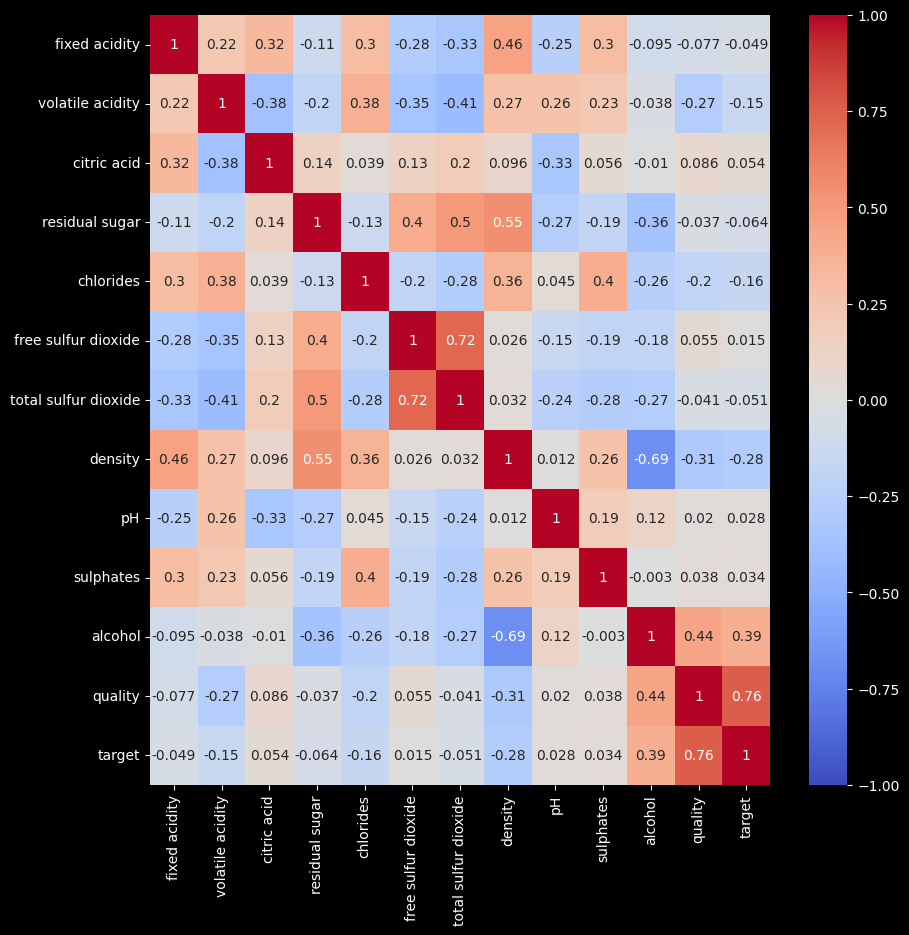

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['dark_background'])

sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.gcf().set_size_inches(10,10)

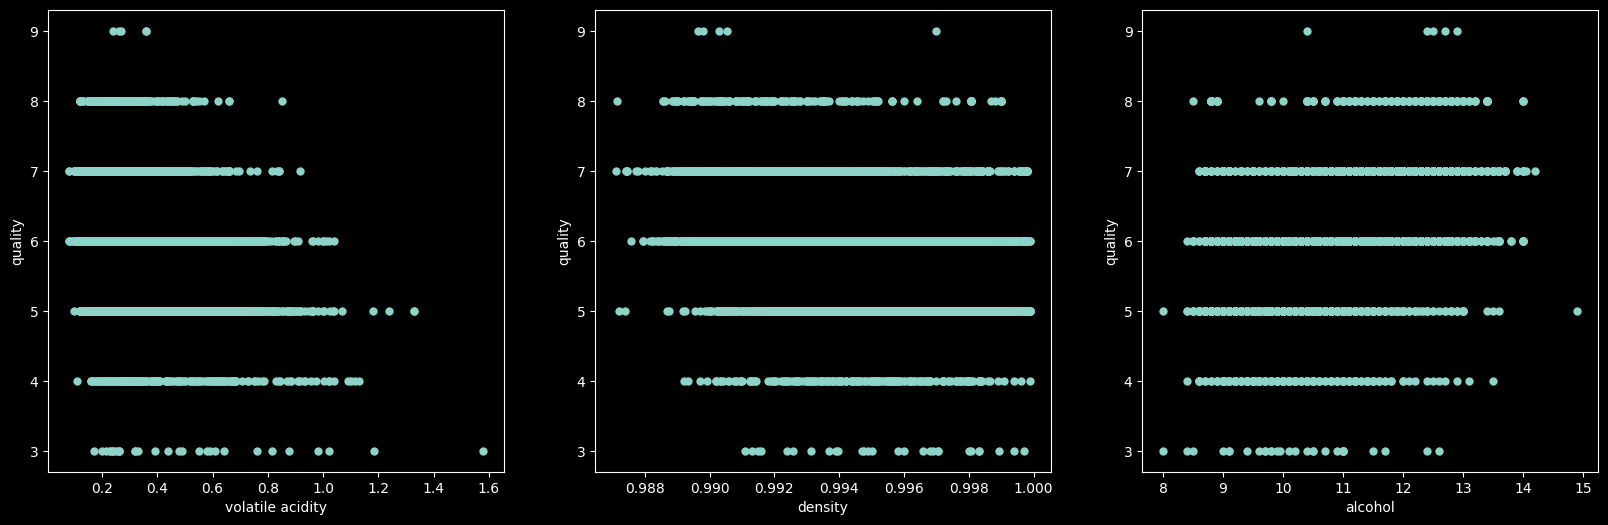

In [12]:
# 상관곗 (0.2) 이상의 상관관계를 가지는 변수 탐색
# 등급이 올라갈수록 volatile acidity가 낮아지는 경향성 보임
fig, axes = plt.subplots(1, 3)
sns.scatterplot(data=df, x='volatile acidity', y='quality', linewidth=0, ax=axes[0])
sns.scatterplot(data=df, x=df[df['density']<1]['density'], y=df[df['density']<1]['quality'], linewidth=0, ax=axes[1])
sns.scatterplot(data=df, x='alcohol', y='quality', linewidth=0, ax=axes[2])
plt.gcf().set_size_inches(20,6)

## Session 2
## 선형회귀 활용 중요인자 도출

### 모델링을 위한 데이터 준비
---
* 모델링을 수항하기 위해 Feature와 예측하고자 하는 값인 Y로 데이터를 나눔  
* 학습과 예측을 위한 Train/Test set 분할

In [13]:
# 모델링을 학습하기 위한 Feature(X)와 Y데이터 구분
from sklearn.model_selection import train_test_split
from sklearn import metrics

X=df.drop(['quality','target'], axis=1)
Y=df['quality']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4547, 11)
(4547,)
(1950, 11)
(1950,)


### 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가  
* 선형회귀 실습에서 사전에 정의한 Target을 사용하지 않고, 기존 Quality(1~9등급) 예측

In [14]:
# LR(선형회귀) 모델 활용
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(x_train, y_train )

LinearRegression()

In [15]:
# 예측
# 예측은 학습에 사용된 Data와 Test Data 모두 예측하고 평가
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
y_pred_train = mlr.predict(x_train)
y_pred_test = mlr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print('mae_train(mae): ', mae_train)
r2_train = r2_score(y_train, y_pred_train)
print('r2_train(r2): ', r2_train)
print('')
mae_test = mean_absolute_error(y_test, y_pred_test)
print('mae_test(mae): ', mae_test)
r2_test = r2_score(y_test, y_pred_test)
print('r2_test(r2): ', r2_test)

mae_train(mae):  0.568690415435818
r2_train(r2):  0.2919356745648931

mae_test(mae):  0.5677399977067976
r2_test(r2):  0.29111515391809706


In [16]:
# 실제 값과 예측 값에 대해 표현
df_result = pd.DataFrame({'Real Values': y_test, 'Predicted Values':y_pred_test}).reset_index(drop=True)
df_result['diff'] = df_result['Real Values'] - df_result['Predicted Values']
df_result.head()

,Real Values,Predicted Values,diff
0,6,5.715938,0.284062
1,6,6.099112,-0.099112
2,6,5.600057,0.399943
3,5,5.968944,-0.968944
4,7,6.481834,0.518166


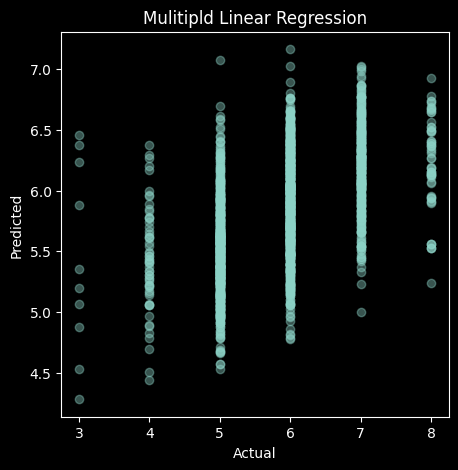

In [17]:
# 예측 모델이 얼마나 실제 문제를 잘 설명하는지 그래프 표현
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred_test, alpha=0.4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Mulitipld Linear Regression')
plt.gcf().set_size_inches(5,5)
plt.show()

In [18]:
# 실제 값과 예측 값에 대해 표현(정수값 변환)
df_result=pd.DataFrame({'Real Values': y_test, 'Predicted Values':list(round(df_result['Predicted Values'],0))})
df_result['diff'] = df_result['Real Values'] - df_result['Predicted Values']
df_result.head()

,Real Values,Predicted Values,diff
1373,6,6.0,0.0
1248,6,6.0,0.0
1404,6,6.0,0.0
2334,5,6.0,-1.0
1238,7,6.0,1.0


In [19]:
abs(df_result['diff']).mean()

0.5256410256410257

In [20]:
y_pred_test

array([5.71593841, 6.09911206, 5.60005681, ..., 6.45777201, 5.63280617,
       6.3724629 ])

In [21]:
np.round(y_pred_test,0).astype(int)

array([6, 6, 6, ..., 6, 6, 6])

In [22]:
# 변형된 y값에 대한 MAE
pred_test = np.round(y_pred_test,0).astype(int)
mae_test = mean_absolute_error(y_test, pred_test)
print('mae_test(mae): ', mae_test)
r2_test = r2_score(y_test, np.round(y_pred_test,0))
print('r2_score(r2): ', r2_test)

mae_test(mae):  0.5256410256410257
r2_score(r2):  0.16903716422381765


### 다중 회귀 상관계수 확인
---
* 회귀식의 장점 : 계수로 어느 정도 설명 가능함.

In [23]:
df_coef = pd.DataFrame({'col':X.columns, 'coef':mlr.coef_}).reset_index(drop=True)
df_coef

,col,coef
0,fixed acidity,0.070338
1,volatile acidity,-1.341506
2,citric acid,-0.057154
3,residual sugar,0.045777
4,chlorides,-0.341920
5,free sulfur dioxide,0.004875
6,total sulfur dioxide,-0.002343
7,density,-55.589774
8,pH,0.478424
9,sulphates,0.772807


In [24]:
# 다중공선성 제거, 무엇에 의해 결과가 나왔는지 해석하기 어려우므로 진행되어야 함.
# 분석 결과인 회귀 계수가 불안정하며, 회귀계수가 해당 변수의 종속변수에 미치는 영향력을 올바로 설명하지 못함
df_corr = df.corr()
df_corr = df_corr[(abs(df_corr) > 0.5) & (df_corr != 1)]
df_corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
fixed acidity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volatile acidity,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
citric acid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
residual sugar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.552517,NaN,NaN,NaN,NaN,NaN
chlorides,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
free sulfur dioxide,NaN,NaN,NaN,NaN,NaN,NaN,0.720934,NaN,NaN,NaN,NaN,NaN,NaN
total sulfur dioxide,NaN,NaN,NaN,NaN,NaN,0.720934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
density,NaN,NaN,NaN,0.552517,NaN,NaN,NaN,NaN,NaN,NaN,-0.686745,NaN,NaN
pH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sulphates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# (density, residual sugar) → 0.552517
# (total sulfur dioxide, free sulfur dioxide) → 0.720934
# (alcohol, pH) → 0.720934

from sklearn.model_selection import train_test_split
from sklearn import metrics

X=df.drop(['quality', 'target', 'residual sugar', 'total sulfur dioxide', 'pH'], axis=1)
Y=df['quality']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(4547, 8)
(4547,)
(1950, 8)
(1950,)


In [38]:
# LR(선형회귀) 모델 활용
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression()

In [39]:
# 예측
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
y_pred_train = mlr.predict(x_train)
y_pred_test = mlr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print('mae_train(mae):', mae_train)
r2_train = r2_score(y_train, y_pred_train)
print('r2_train(r2):', r2_train)
print('')
mae_test=mean_absolute_error(y_test, y_pred_test)
print('mae_test(mae):', mae_test)
r2_test = r2_score(y_test, y_pred_test)
print('r2_test(r2):', r2_test)

mae_train(mae): 0.574902116857064
r2_train(r2): 0.27951590823885597

mae_test(mae): 0.579971886152098
r2_test(r2): 0.2744942009785476


In [40]:
# Density의 회귀계수 부호가 바뀜
df_coef_2 = pd.DataFrame({'col':X.columns, 'coef':mlr.coef_}).reset_index(drop=True)
df_coef_2

,col,coef
0,fixed acidity,0.001385
1,volatile acidity,-1.527399
2,citric acid,-0.168864
3,chlorides,-0.631127
4,free sulfur dioxide,0.003034
5,density,37.595180
6,sulphates,0.564817
7,alcohol,0.382707


In [41]:
df_sc = df.copy()

In [45]:
# minmax_scale 표준화

from sklearn.preprocessing import minmax_scale

for i in list(df.columns[0:11]) :
  df_sc[i] = minmax_scale(df_sc[i], axis=0, copy=True)

df_sc.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,0.297521,0.413333,0.000000,0.019939,0.111296,0.034722,0.064516,0.206092,0.612403,0.191011,0.202899,5,0
1,0.330579,0.533333,0.000000,0.030675,0.147841,0.083333,0.140553,0.186813,0.372093,0.258427,0.260870,5,0
2,0.330579,0.453333,0.024096,0.026074,0.137874,0.048611,0.110599,0.190669,0.418605,0.241573,0.260870,5,0
3,0.611570,0.133333,0.337349,0.019939,0.109635,0.055556,0.124424,0.209948,0.341085,0.202247,0.260870,6,0
4,0.297521,0.413333,0.000000,0.019939,0.111296,0.034722,0.064516,0.206092,0.612403,0.191011,0.202899,5,0


In [46]:
# (density, residual sugar) → 0.552517
# (total sulfur dioxide, free sulfur dioxide) → 0.720934
# (pH, alcohol) → 0.720934

from sklearn.model_selection import train_test_split
from sklearn import metrics

X=df_sc.drop(['quality', 'target', 'residual sugar', 'total sulfur dioxide', 'pH'], axis=1)
Y=df_sc['quality']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(4547, 8)
(4547,)
(1950, 8)
(1950,)


In [47]:
# LR 모델 활용
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression()

In [48]:
# 예측
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
y_pred_train = mlr.predict(x_train)
y_pred_test = mlr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print('mae_train(mae):', mae_train)
r2_train = r2_score(y_train, y_pred_train)
print('r2_train(r2):', r2_train)
print('')
mae_test=mean_absolute_error(y_test, y_pred_test)
print('mae_test(mae):', mae_test)
r2_test = r2_score(y_test, y_pred_test)
print('r2_test(r2):', r2_test)

mae_train(mae): 0.5833727219652187
r2_train(r2): 0.2703347519952245

mae_test(mae): 0.5599585645169355
r2_test(r2): 0.29374435488981543


In [51]:
# Scaling을 통해 해석하기 쉬워짐
df_coef_3 = pd.DataFrame({'col':X.columns, 'coef':mlr.coef_}).reset_index(drop=True)
df_coef_3

,col,coef
0,fixed acidity,-0.039709
1,volatile acidity,-2.207478
2,citric acid,-0.443935
3,chlorides,-0.086587
4,free sulfur dioxide,1.442533
5,density,1.565131
6,sulphates,1.042904
7,alcohol,2.577169


## Session 3
## ML 활용 품질 중요인자 도출

In [52]:
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,1
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,0


### 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위헤 Feature와 예측하고자하는 값인 Y로 데이터를 나눔  
* 학습과 예측을 위한 Train/Test set 분할

In [53]:
# 데이터 set 구분
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 세트 로드
X=df.drop(['quality','target'], axis=1)
Y=df['target']

# split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# 데이터 세트를 적절한 LGB 형식으로 변환
d_train=lgb.Dataset(x_train, label=y_train)

### 모델 학습 및 평가
---
* 모델을 학습하고 예측을 수행하여 성능을 평가

In [54]:
# setting the parameters
params={}
params['learning_rate']=0.02
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'
params['max_depth']=3
params['num_leaves']=6
params['seed']=23456
# 모델 학습
clf = lgb.train (params, d_train, 1000)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 894, number of negative: 3653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 4547, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.196613 -> initscore=-1.407598
[LightGBM] [Info] Start training from score -1.407598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [55]:
y_pred_train  = clf.predict(x_train)
y_pred_train

array([0.25551067, 0.74019909, 0.00162448, ..., 0.00280172, 0.29956017,
       0.11305495])

In [57]:
from sklearn.metrics import classification_report

y_pred_train = clf.predict(x_train)
for i in range(0,len(y_pred_train)):
    if y_pred_train[i]>=.5:       # setting threshold to .5
       y_pred_train[i]=1
    else:
       y_pred_train[i]=0

y_pred_test = clf.predict(x_test)
for i in range(0,len(y_pred_test)):
    if y_pred_test[i]>=.5:       # setting threshold to .5
       y_pred_test[i]=1
    else:
       y_pred_test[i]=0

print(classification_report(y_train, y_pred_train))
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      3653
           1       0.80      0.53      0.63       894

    accuracy                           0.88      4547
   macro avg       0.84      0.75      0.78      4547
weighted avg       0.87      0.88      0.87      4547

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1567
           1       0.67      0.40      0.50       383

    accuracy                           0.84      1950
   macro avg       0.77      0.68      0.71      1950
weighted avg       0.83      0.84      0.83      1950



### 중요 변수 파악
---
* Feature IMP 분석을 통한 중요변수 파악

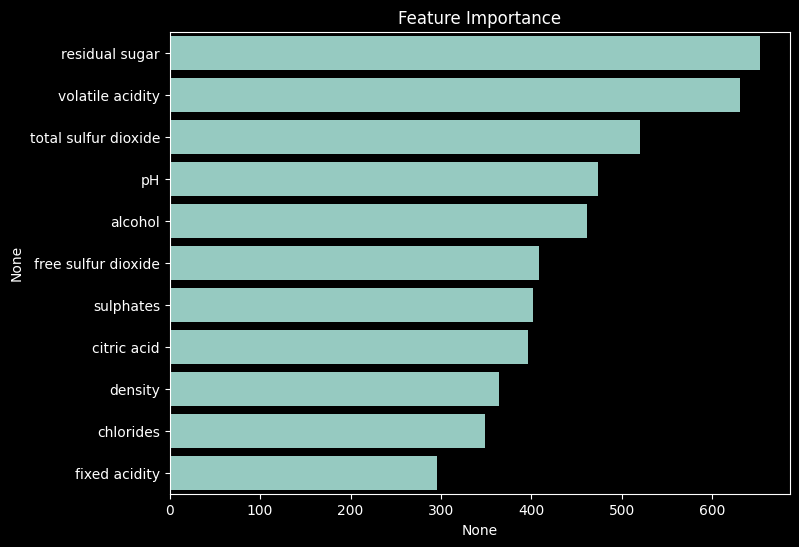

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use(['dark_background'])

ftr_importances_values = clf.feature_importance()
ftr_importances = pd.Series(ftr_importances_values, index=X.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:21]

plt.figure(figsize=(8,6))
plt.title('Feature Importance')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()